In [31]:
import random
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, matthews_corrcoef
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

In [36]:
features = "pca_mfcc_20_no_pitch_1000_rand_all_speakers"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

print(len(mfcc_stats_dict.keys()))

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

245
reader: 103 | # samples 1000
reader: 1034 | # samples 1000
reader: 1069 | # samples 1000
reader: 1081 | # samples 1000
reader: 1088 | # samples 1000
reader: 1098 | # samples 1000
reader: 1116 | # samples 1000
reader: 118 | # samples 1000
reader: 1235 | # samples 1000
reader: 1246 | # samples 1000
reader: 125 | # samples 1000
reader: 1263 | # samples 1000
reader: 1334 | # samples 1000
reader: 1355 | # samples 1000
reader: 1363 | # samples 1000
reader: 1447 | # samples 1000
reader: 1455 | # samples 1000
reader: 150 | # samples 1000
reader: 1502 | # samples 1000
reader: 1553 | # samples 1000
reader: 1578 | # samples 1000
reader: 1594 | # samples 1000
reader: 1624 | # samples 1000
reader: 163 | # samples 1000
reader: 1723 | # samples 1000
reader: 1737 | # samples 1000
reader: 1743 | # samples 1000
reader: 1841 | # samples 1000
reader: 1867 | # samples 1000
reader: 1898 | # samples 1000
reader: 19 | # samples 1000
reader: 1926 | # samples 1000
reader: 196 | # samples 1000
reader: 1963 |

In [37]:
def save_metrics_kfold(metric_dict, output_file=f"./metrics"):

    accuracies = [metrics['accuracy'] for metrics in metric_dict.values()]
    precisions = [metrics['precision'] for metrics in metric_dict.values()]
    recalls = [metrics['recall'] for metrics in metric_dict.values()]
    f1_scores = [metrics['f1'] for metrics in metric_dict.values()]
    roc_aucs = [metrics['roc_auc'] for metrics in metric_dict.values()] # correct this
    mse = [metrics['mse'] for metrics in metric_dict.values()]
    eers = [metrics['eer'] for metrics in metric_dict.values()]
    mcc = [metrics['mcc'] for metrics in metric_dict.values()]

    def five_num_summary(values):
        return {
            'min': np.min(values),
            'q1': np.percentile(values, 25),
            'median': np.median(values),
            'q3': np.percentile(values, 75),
            'max': np.max(values),
            'mean': np.mean(values)
        }
    
    accuracy_summary = five_num_summary(accuracies)
    precision_summary = five_num_summary(precisions)
    recall_summary = five_num_summary(recalls)
    f1_summary = five_num_summary(f1_scores)
    mse_summary = five_num_summary(mse)
    roc_auc_summary = five_num_summary(roc_aucs)
    eer_summary = five_num_summary(eers)  
    mcc_summary = five_num_summary(mcc)  

    with open(output_file, 'w') as f:
        f.write(f"summary: \n")
        f.write(f"    five num sum accuracy : {accuracy_summary['min']:.4f} | {accuracy_summary['q1']:.4f} | {accuracy_summary['median']:.4f} | {accuracy_summary['q3']:.4f} | {accuracy_summary['max']:.4f} | mean: {accuracy_summary['mean']:.4f}\n")
        f.write(f"    five num sum precision: {precision_summary['min']:.4f} | {precision_summary['q1']:.4f} | {precision_summary['median']:.4f} | {precision_summary['q3']:.4f} | {precision_summary['max']:.4f} | mean: {precision_summary['mean']:.4f}\n")
        f.write(f"    five num sum recall   : {recall_summary['min']:.4f} | {recall_summary['q1']:.4f} | {recall_summary['median']:.4f} | {recall_summary['q3']:.4f} | {recall_summary['max']:.4f} | mean: {recall_summary['mean']:.4f}\n")
        f.write(f"    five num sum F1-score : {f1_summary['min']:.4f} | {f1_summary['q1']:.4f} | {f1_summary['median']:.4f} | {f1_summary['q3']:.4f} | {f1_summary['max']:.4f} | mean: {f1_summary['mean']:.4f}\n")
        f.write(f"    five num sum ROC AUC  : {roc_auc_summary['min']:.4f} | {roc_auc_summary['q1']:.4f} | {roc_auc_summary['median']:.4f} | {roc_auc_summary['q3']:.4f} | {roc_auc_summary['max']:.4f} | mean: {roc_auc_summary['mean']:.4f}\n")
        f.write(f"    five num sum MSE      : {mse_summary['min']:.4f} | {mse_summary['q1']:.4f} | {mse_summary['median']:.4f} | {mse_summary['q3']:.4f} | {mse_summary['max']:.4f} | mean: {mse_summary['mean']:.4f}\n")
        f.write(f"    five num sum EER      : {eer_summary['min']:.4f} | {eer_summary['q1']:.4f} | {eer_summary['median']:.4f} | {eer_summary['q3']:.4f} | {eer_summary['max']:.4f} | mean: {eer_summary['mean']:.4f}\n")
        f.write(f"    five num sum MCC      : {mcc_summary['min']:.4f} | {mcc_summary['q1']:.4f} | {mcc_summary['median']:.4f} | {mcc_summary['q3']:.4f} | {mcc_summary['max']:.4f} | mean: {mcc_summary['mean']:.4f}\n")
        
        f.write("\n")

        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    accuracy: {metrics['accuracy']:.4f}\n")
            f.write(f"    precision: {metrics['precision']:.4f}\n")
            f.write(f"    recall: {metrics['recall']:.4f}\n")
            f.write(f"    F1-score: {metrics['f1']:.4f}\n")
            f.write(f"    ROC AUC: {metrics['roc_auc']:.4f}\n")
            f.write(f"    MSE: {metrics['mse']:.4f}\n")
            f.write(f"    EER: {metrics['eer']:.4f}\n")
            f.write(f"    MCC: {metrics['mcc']:.4f}\n")

        f.write("\n")

    return metric_dict

def plot_roc_cross_validation(metrics, save_dir=None):
    """
    Plots the ROC curve for cross-validation results.
    
    Parameters:
        metrics (list): A list of metrics dictionaries from cross-validation.
        save_dir (str): Directory to save the plot.
    """
    plt.figure(figsize=(10, 8))

    for speaker in metrics.keys():
        plt.plot(metrics[speaker]["best_model"]['fpr'], metrics[speaker]["best_model"]['tpr'])

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for SVM Cross-Validation')
    plt.legend(loc="lower right")
    plt.grid()

    if save_dir:    
        plt.savefig(save_dir)
    plt.show()
    plt.close()

def print_metrics(metrics):
    print("Model Evaluation Metrics:")
    for key, value in metrics.items():
        if isinstance(value, np.float64):
            print(f"{key.capitalize()}: {value:.4f}")
        elif isinstance(value, dict):
            print(f"{key.capitalize()}:")
            print_metrics(value)  # Recursive call for nested dictionaries
        elif isinstance(value, np.ndarray):
            print(f"{key.capitalize()}: Array of {len(value)} elements")
        else:
            print(f"{key.capitalize()}: {value}")

In [38]:
def generate_random_indices(n, x, seed=42):
    if n > x + 1:
        raise ValueError("Cannot generate more unique numbers than the specified range.")
    
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(range(0, x), n)

def generate_binary_test_set(data_dict, key):
    if key not in data_dict:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    true_values = data_dict[key] # Get the list corresponding to the key

    num_other_classes = len(data_dict.keys()) - 1
    num_of_true_samples = len(true_values)

    samples_per_class = num_of_true_samples // num_other_classes
    # print(f"samples per class: {samples_per_class}")

    random_indices = generate_random_indices(samples_per_class, num_of_true_samples)

    test_set = true_values.copy()  # Start with the list for the specified key
    
    if isinstance(test_set, np.ndarray):
        test_set = test_set.tolist()

    for k, v in data_dict.items():
        if k != key:  # Skip the list that corresponds to the key
            for i in random_indices:
                test_set.append(v[i])

    return test_set, num_of_true_samples

def split_dict(data, train_ratio=0.8):
    random.seed(42)
    keys = list(data.keys())
    random.shuffle(keys)  # Shuffle the keys to randomize the split
    split_point = int(len(keys) * train_ratio)
    
    train_keys = keys[:split_point]
    test_keys = keys[split_point:]
    
    train_dict = {key: data[key] for key in train_keys}
    test_dict = {key: data[key] for key in test_keys}
    
    return train_dict, test_dict

def get_random_entries(original_dict, n):
    """
    Selects n random entries from the input dictionary.

    Args:
        original_dict (dict): The original dictionary to select entries from.
        n (int): The number of random entries to select.

    Returns:
        dict: A new dictionary containing n randomly selected entries.

    Raises:
        ValueError: If n is greater than the number of entries in the dictionary.
    """
    random.seed(42)

    if n > len(original_dict):
        raise ValueError("n cannot be greater than the number of entries in the dictionary.")

    random_keys = random.sample(list(original_dict.keys()), n)
    return {key: original_dict[key] for key in random_keys}

In [39]:
def calculate_eer(fpr, tpr):
    """Calculate Equal Error Rate (EER)."""
    fnr = 1 - tpr
    eer_threshold_index = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_threshold_index] + fnr[eer_threshold_index]) / 2
    return eer

def cnn_cross_validate(data_dict, key, n_folds, model):
    data, segments_length = generate_binary_test_set(data_dict, key)
    data = np.vstack(data)
    ground_truth = np.array([0] * segments_length + [1] * (len(data) - segments_length))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    metrics_list = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "mse": [],
        "eer": [],
        "mcc": [],
    }

    best_model_metrics = {
        "fpr" : None,
        "tpr" : None,
        "roc_auc": 0.0,
        "eer": None,
        "model": None,
    }
    
    class FinalMetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            self.final_logs = logs

    for train_idx, test_idx in kf.split(data):
        data_train, data_test = data[train_idx], data[test_idx]
        label_train, label_test = ground_truth[train_idx], ground_truth[test_idx]
        
        label_train = tf.expand_dims(label_train, axis=-1)
        label_test = tf.expand_dims(label_test, axis=-1)

        final_metrics_callback = FinalMetricsCallback()
        model.fit(data_train, label_train, epochs=10, batch_size=32, validation_data=(data_test, label_test), callbacks=[final_metrics_callback])

        test_pred_prob = model.predict(data_test).flatten() 
        fpr, tpr, thresholds = roc_curve(label_test, test_pred_prob)
        test_pred_binary = (test_pred_prob >= 0.5).astype(int)

        metrics_list["accuracy"].append(final_metrics_callback.final_logs.get("accuracy", 0))
        metrics_list["precision"].append(final_metrics_callback.final_logs.get("precision", 0))
        metrics_list["recall"].append(final_metrics_callback.final_logs.get("recall", 0))
        metrics_list["f1"] .append(final_metrics_callback.final_logs.get("F1Score", 0))
        metrics_list["roc_auc"].append(final_metrics_callback.final_logs.get("AUC", 0))
        metrics_list["mse"].append(final_metrics_callback.final_logs.get("MeanSquaredError", 0))
        metrics_list["mcc"].append(matthews_corrcoef(label_test, test_pred_binary))

        roc_auc = final_metrics_callback.final_logs.get("AUC", 0)
        metrics_list["roc_auc"].append(roc_auc)
        eer = calculate_eer(fpr, tpr)
        metrics_list["eer"].append(eer)

        # Update the best model if the current fold has a better ROC AUC score
        if roc_auc > best_model_metrics["roc_auc"]:
            # fpr, tpr, _ = roc_curve(label_test, decision_scores)
            best_model_metrics["fpr"] = fpr
            best_model_metrics["tpr"] = tpr
            best_model_metrics["roc_auc"] = roc_auc
            best_model_metrics["eer"] = eer  # Save EER for the best model
            best_model_metrics["model"] = model  # Save the best SVM model

    # Compute the mean of each metric
    mean_metrics = {
        metric: (np.mean(scores) if metric not in ["fpr", "tpr"] else scores)
        for metric, scores in metrics_list.items()
    }
    mean_metrics["best_model"] = best_model_metrics

    return mean_metrics

def cnn_cross_validate_wrapper(data_dict, model, n_folds=5):
    metric_dict = {}

    for key in data_dict.keys():
        metric_dict[key] = cnn_cross_validate(data_dict, key, n_folds, model)

    return(metric_dict)

In [45]:
model_1 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_2 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_3 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_4 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_5 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_5.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_6 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_6.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_7 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_7.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_8 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_8.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_9 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_9.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_10 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=5, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_10.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_11 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_11.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_12 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='sigmoid'),
    layers.Conv1D(32, kernel_size=3, activation='sigmoid'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_12.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_13 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='softmax'),
    layers.Conv1D(32, kernel_size=3, activation='softmax'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='softmax'),
    layers.Dense(32, activation='softmax'),
    layers.Dense(16, activation='softmax'),
    layers.Dense(8, activation='softmax'),
    layers.Dense(1, activation='sigmoid')
])
model_13.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)

model_14 = models.Sequential([
    layers.Input(shape=(71,1)),
    layers.Conv1D(32, kernel_size=3, activation='sigmoid'),
    layers.Conv1D(32, kernel_size=3, activation='sigmoid'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])
model_14.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary classification
    metrics=["accuracy", "precision", "recall", "F1Score", "AUC", "MeanSquaredError"]
)


In [46]:
mfcc_stats_dict_small = get_random_entries(mfcc_stats_dict, 25)
metrics_and_models_small = cnn_cross_validate_wrapper(mfcc_stats_dict_small, model_14, 5)
save_metrics_kfold(metrics_and_models_small, output_file=f"./metrics/CNN/k-fold_{features}_model_14.txt")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.5218 - F1Score: 0.6455 - MeanSquaredError: 0.2538 - accuracy: 0.5230 - loss: 0.7010 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_F1Score: 0.6811 - val_MeanSquaredError: 0.2502 - val_accuracy: 0.4836 - val_loss: 0.6935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4784 - F1Score: 0.6539 - MeanSquaredError: 0.2500 - accuracy: 0.5140 - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_F1Score: 0.6811 - val_MeanSquaredError: 0.2501 - val_accuracy: 0.4836 - val_loss: 0.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4678 - F1Score: 0.6487 - MeanSquaredError: 0.2500 - accuracy: 0.5197 - loss: 0.6931 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5000 - val_F1Score: 0.6811 - val_MeanSquaredError: 0.2505 - val_accuracy: 0.4836 - val_loss

{'6000': {'accuracy': np.float64(0.6661669373512268),
  'precision': np.float64(0.6643389463424683),
  'recall': np.float64(0.7913922011852265),
  'f1': np.float64(0.6630385279655456),
  'roc_auc': np.float64(0.6708849430084228),
  'mse': np.float64(0.1756948634982109),
  'eer': np.float64(0.16062962845735593),
  'mcc': np.float64(0.33909948887508434),
  'best_model': {'fpr': array([0.        , 0.        , 0.        , 0.00555556, 0.00555556,
          0.01111111, 0.01111111, 0.01666667, 0.01666667, 0.02222222,
          0.02222222, 0.03333333, 0.03333333, 0.03888889, 0.03888889,
          0.04444444, 0.04444444, 0.05      , 0.05      , 0.06666667,
          0.06666667, 0.08333333, 0.08333333, 0.08888889, 0.08888889,
          0.15555556, 0.15555556, 0.78333333, 0.79444444, 1.        ]),
   'tpr': array([0.        , 0.00462963, 0.69444444, 0.69444444, 0.7037037 ,
          0.7037037 , 0.73611111, 0.73611111, 0.82407407, 0.82407407,
          0.93055556, 0.93055556, 0.96296296, 0.9629629

In [29]:
metrics_and_models = cnn_cross_validate_wrapper(mfcc_stats_dict, model_8, 5)
# took 41 min and 43.2 seconds for pca mfcc 20

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9196 - F1Score: 0.6630 - MeanSquaredError: 0.1288 - accuracy: 0.8288 - loss: 0.3989 - precision: 0.8855 - recall: 0.7254 - val_AUC: 0.9959 - val_F1Score: 0.6777 - val_MeanSquaredError: 0.0208 - val_accuracy: 0.9749 - val_loss: 0.0814 - val_precision: 0.9533 - val_recall: 1.0000
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9988 - F1Score: 0.6615 - MeanSquaredError: 0.0115 - accuracy: 0.9868 - loss: 0.0442 - precision: 0.9874 - recall: 0.9860 - val_AUC: 0.9963 - val_F1Score: 0.6777 - val_MeanSquaredError: 0.0283 - val_accuracy: 0.9623 - val_loss: 0.1064 - val_precision: 0.9355 - val_recall: 0.9951
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9987 - F1Score: 0.6514 - MeanSquaredError: 0.0145 - accuracy: 0.9781 - loss: 0.0502 - precision: 0.9701 - recall: 0.9860 - val_AUC: 0.9984 - val_F1Score: 0.6777 - val_MeanSquaredError: 0.0134 - val_accuracy: 0.9824 - val_loss: 0.0504 - val_precision: 0.9950 - val_r

In [30]:
save_metrics_kfold(metrics_and_models, output_file=f"./metrics/CNN/k-fold_{features}_model_8_all.txt")

{'1069': {'accuracy': np.float64(0.998490571975708),
  'precision': np.float64(0.9989743590354919),
  'recall': np.float64(0.9979591846466065),
  'f1': np.float64(0.6868149280548096),
  'roc_auc': np.float64(0.9999675631523133),
  'mse': np.float64(0.0010444663227840768),
  'eer': np.float64(0.003016979987871432),
  'mcc': np.float64(0.9879916235994186),
  'best_model': {'fpr': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1.]),
   'tpr': array([0.        , 0.04736842, 0.08947368, 0.11578947, 0.14736842,
          0.21052632, 0.23684211, 0.28421053, 0.29473684, 0.31578947,
          0.32105263, 0.34210526, 0.34736842, 0.35789474, 0.37368421,
          0.40526316, 0.41578947, 0.42105263, 0.43157895, 0.44736842,
          0.65789474, 0.66842105, 0.72105263, 0.73157895, 1.        ,
          1.        ]),
   'roc_auc': 1.0,
   'eer': np.float64(0.0),
   'model': <Sequential name=sequential_73, built=True>}},
 '19': {'a

C:\Users\odink\AppData\Local\Temp\ipykernel_16396\3785690312.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


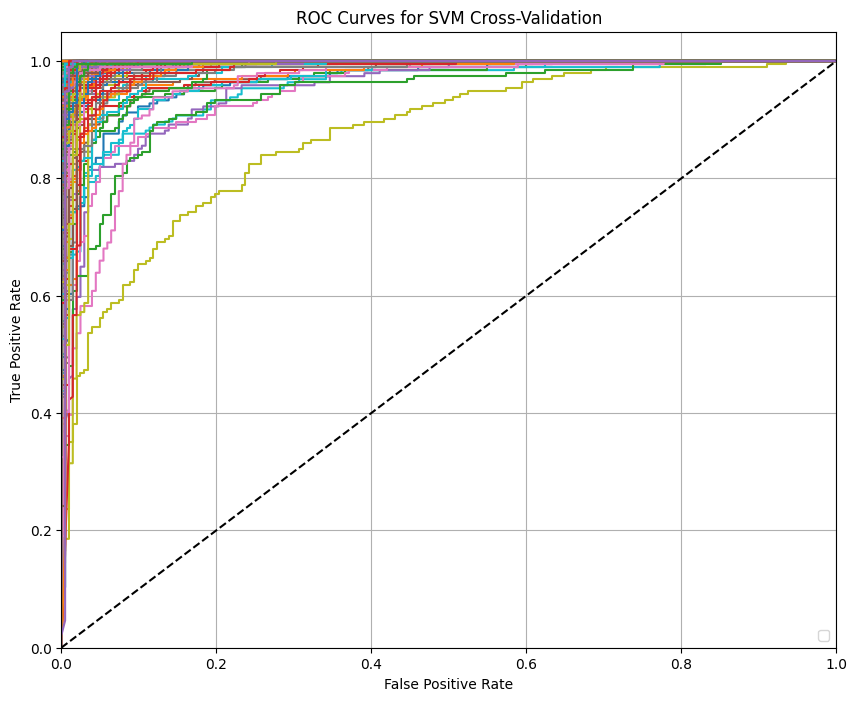

In [9]:
plot_roc_cross_validation(metrics_and_models, save_dir=f"./metrics/CNN/plots/k-fold_{features}")

In [ ]:
cnn_cross_validate(mfcc_stats_dict, "1034", 5, model_1)

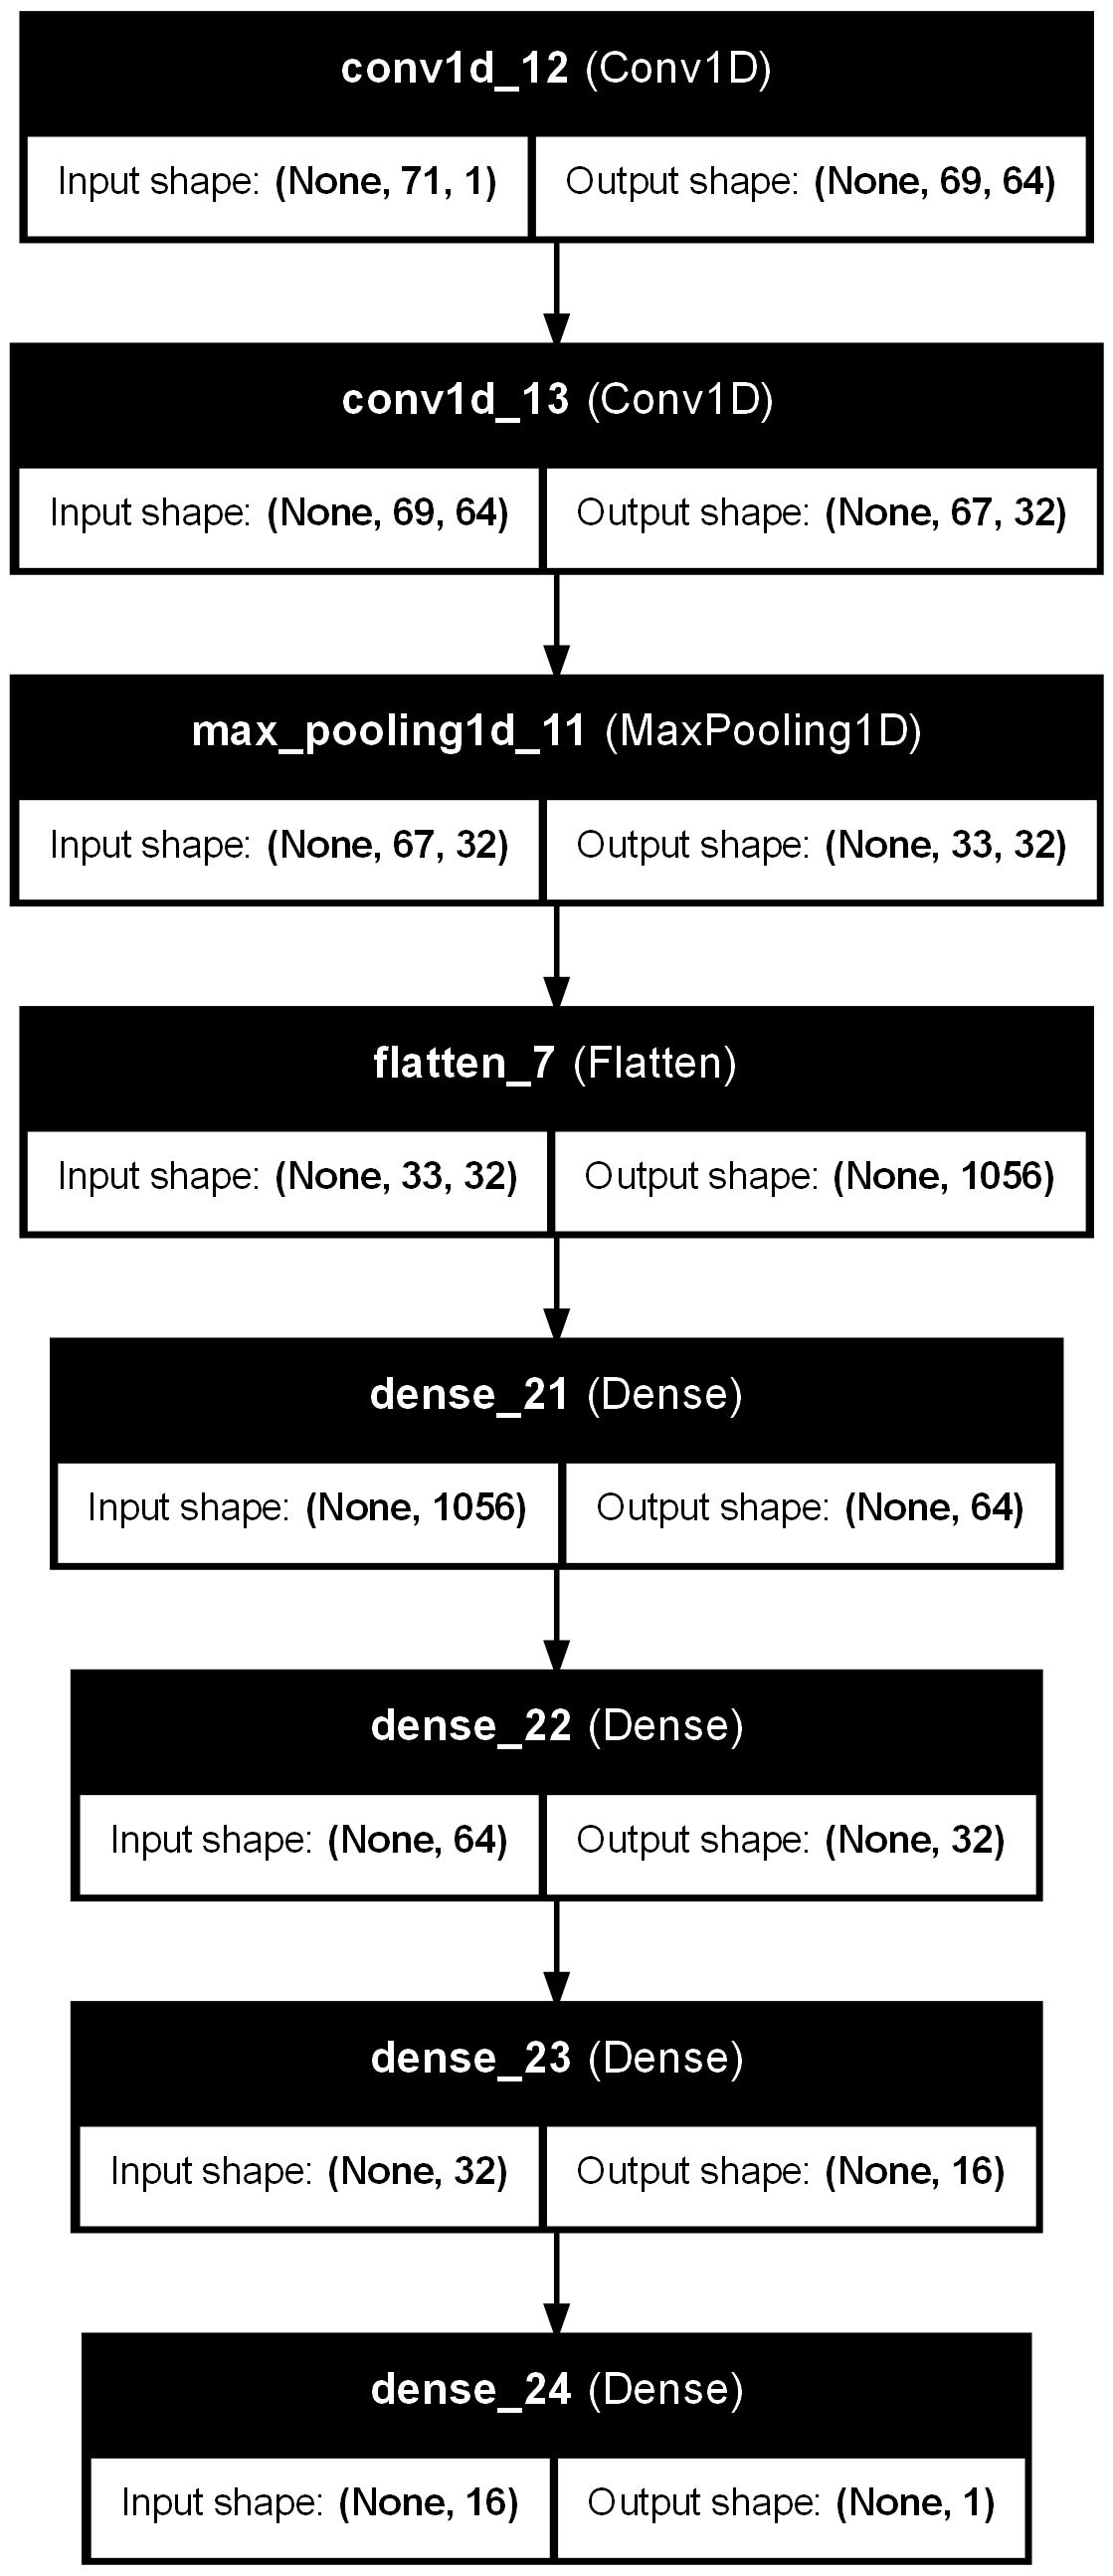

In [3]:
plot_model(model_8, to_file="./model_8.png", show_shapes=True, show_layer_names=True)